## Preparation

In [1]:
# Import Libraries
import seaborn
import pandas as pd
import numpy as np
import urllib
import re
import math
import matplotlib.pyplot as plt

# Import Libraries for machine learning
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

## Data Loading

## Predict Water Vapour (H2O)

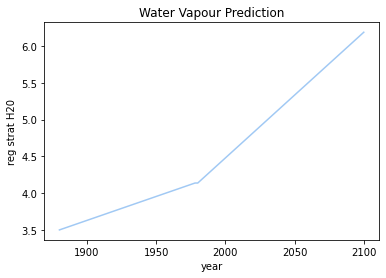

In [8]:
variables = pd.DataFrame()
seaborn.set_palette("pastel")

# Load data
bld_water_vapour = pd.read_csv('https://universalresearchcenter.com/static/bld_water_vapour.csv', 
                               parse_dates=['launch_timestamp'])

agg = bld_water_vapour[bld_water_vapour['Alt (km)'] >= 18]
agg = agg[agg['Alt (km)'] <= 28]
agg['year'] = agg['launch_timestamp'].dt.year
yearly = agg.groupby('year').mean()

yearly.tail()
water_vapour = yearly
water_vapour.reset_index(inplace = True)

X_wv = list(water_vapour['year'])
Y_wv = list(water_vapour['H2Omr_orig (ppmv)'])

# Transform the data to include another axis
x_wv = np.array(X_wv)[:, np.newaxis]
y_wv = np.array(Y_wv)[:, np.newaxis]

Xtend_wv = X_wv + [2021 + i for i in range(80)]
MXtend_wv = np.array(Xtend_wv)[:, np.newaxis]

model = LinearRegression()
model.fit(x_wv, y_wv)
y_pred_wv = model.predict(MXtend_wv)

degree = 2

MX_wv = np.array(X_wv)[:, np.newaxis]

model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(MX_wv, Y_wv)
y_plot_wv = model.predict(MXtend_wv)

past = list(np.linspace(3.5,list(y_pred_wv.flatten())[0],99))

past_years = list(range(1880, 1979))

df_h2o = pd.DataFrame()
df_h2o['year'] = past_years + Xtend_wv
df_h2o['reg strat H20'] = past + list(y_pred_wv.flatten())

variables['year'] = df_h2o['year']
variables['proj h2o'] = past + Y_wv + list(y_pred_wv.flatten())[-80:]

s = seaborn.lineplot(data = df_h2o, x = 'year' , y = 'reg strat H20').set(title = "Water Vapour Prediction")



## Predict Carbon Dioxide (CO2)

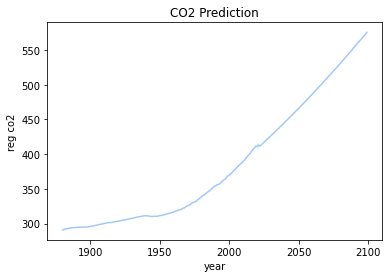

In [11]:
co2_source = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_annmean_mlo.txt"

co2 = pd.read_csv(co2_source,sep = '\s+', comment = '#', names = ['year', 'mean','unc']) # year is index
co2 = co2[co2['year']>=1880]

# Retrieve old CO2 data
old_co2_source = "https://data.giss.nasa.gov/modelforce/ghgases/Fig1A.ext.txt"

txt = urllib.request.urlopen(old_co2_source).readlines()

d={}
for line in txt[5:55]:
    p = re.sub(r'[a-zA-Z&\-\/]', ' ', line.decode('utf-8'))
    l = p.split()
    d[int(l[0])] = float(l[1])
    d[int(l[2])] = float(l[3])
    d[int(l[4])] = float(l[5])

X_co2 = list(co2['year'])
Y_co2 = list(co2['mean'])

# Transform the data to include another axis
x_co2 = np.array(X_co2)[:, np.newaxis]
y_co2 = np.array(Y_co2)[:, np.newaxis]


Xtend_co2 = X_co2 + [2020 + i for i in range(80)]
MXtend_co2 = np.array(Xtend_co2)[:, np.newaxis]

model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(x_co2, y_co2)
y_pred_co2 = model.predict(MXtend_co2)

df_co2 = pd.DataFrame()
df_co2['year'] = list(range(1880,1958)) + Xtend_co2
df_co2['reg co2'] = [d[i] for i in range(1880,1958)] + Y_co2 + list(y_pred_co2.flatten())[-80:]

variables['proj co2'] = df_co2['reg co2']

predicted_co2 = list(y_pred.flatten())

s = seaborn.lineplot(data = df_co2, x = 'year', y = 'reg co2' ).set(title = "Carbon Dioxide Prediction")

## Predict GAT

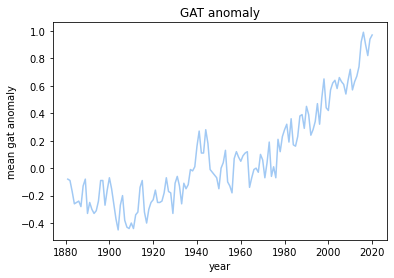

In [13]:
source = "https://www.ncdc.noaa.gov/cag/global/time-series/globe/land_ocean/ytd/12/1880-2020.csv"
data = pd.read_csv(source)[5:]

df_gat = pd.DataFrame()

df_gat['year'] = pd.to_numeric(data['Global Land and Ocean Temperature Anomalies'], downcast="integer")
df_gat['mean gat anomaly'] = pd.to_numeric(data[' January-December'])

df_gat = df_gat[df_gat['year'] >= 1880]
df_gat.head()

s = seaborn.lineplot(data=df_gat, x='year' , y='mean gat anomaly').set(title = "GAT anomaly") 


In [15]:
def plot_temp(co2_prediction, temp_prediction):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, facecolor='lightgray')
    plt.grid(color='w', linestyle='solid')

    ax1.plot(X, Y)
    ax1.plot(MXtend, temp_prediction, 'b')
    ax1.set_ylabel('avg global temperature anomaly')
    plt.hlines(1.50, 1875, 2050, colors='r', alpha=.5)
    plt.hlines(2.0, 1875, 2050, colors='r', alpha=.7)
    plt.ylim(-0.5, 2.2)
    ax2 = ax1.twinx()
    ax2.plot(MXtend, co2_prediction, 'g')
    ax1.legend(['temperature readings', 'temperature prediction'], loc='center left')
    ax2.set_ylim(200, 500)
    ax2.legend([ 'CO2 ppm'], loc='lower right')

    for label in ax2.get_yticklabels():
        label.set_color("green")

    for label in ax1.get_yticklabels():
        label.set_color("blue")

    ax1.errorbar(MXtend[-30],  temp_prediction[-30], yerr=2*rmse, color='black', fmt='o')
    ax1.fill_between(Xtend[-30:],temp_prediction[-30:] - 2*rmse, temp_prediction[-30:] + 2*rmse, alpha=.3)
    plt.show()
    print('Temp 2050 :', temp_prediction[-1])

## Predict GAT from Water Vapour and Carbon Dioxide

In [17]:
degree=1
years = list(df_h2o['year'])
h2o = list(df_h2o['reg strat H20'])
co2 = list(df_co2['reg co2'])

years_gat = list(df_gat['year'])
gat = list(df_gat['mean gat anomaly'])

vars = np.array([[years[i], co2[i], h2o[i]] for i in range(len(years_gat))])
vars_pred = np.array([[years[i], co2[i], h2o[i]] for i in range(len(years))])

vars_notime = np.array([[co2[i], h2o[i]] for i in range(len(years_gat))])
vars_pred_notime = np.array([[co2[i], h2o[i]] for i in range(len(years))])

vars_worst = vars_pred_notime

vars_noh2o = np.array([[years[i], co2[i]] for i in range(len(years_gat))])
vars_pred_noh2o = np.array([[years[i], co2[i]] for i in range(len(years))])

zerorate = np.linspace(100,0,80)

def rec(co, recrate, i):
    if i == 0:
        return co[-80]
    else:
        r = rec(co, recrate, i-1)
        return r +  (co[-80+i] - co[-81+i]) * recrate[i]/100.0

co2_sequestrated = 107.0/2.13

end = co2_sequestrated

absorption_c = np.linspace(0, end, 80)

worst_reduction = np.append(np.array(co2[:-80]), np.array([co2[-80:] - absorption_c[i] for i in range(80)]))
co2_reduction = np.append(np.array(co2[:-80]), np.array([rec(co2[-80:], zerorate, i) - absorption_c[i] for i in range(80)]))
co2_reduction_alone = np.append(np.array(co2[:-80]), np.array([rec(co2[-80:], zerorate, i) for i in range(80)]))

vars_zero = np.array([[years[i], co2_reduction[i], h2o[i]] for i in range(len(years))])
vars_zero_notime = np.array([[co2_reduction[i], h2o[i]] for i in range(len(years))])


# Carbon Sequestration
vars_sequester = np.array([[worst_reduction[i], h2o[i]] for i in range(len(years))])
variables['corrected co2'] = co2_reduction

# Net-zero
vars_reduction_notime = np.array([[co2_reduction_alone[i], h2o[i]] for i in range(len(years))])

vars_zero_noh2o = np.array([[years[i], co2_reduction[i]] for i in range(len(years))])

df_gata = pd.DataFrame()
df_gata['year'] = years

In [18]:
earth_surface = 510.1 # in million km2
sahara_surface = 9.2
earth_deserts_surface = 0.3 * earth_surface * 0.33
earth_bond_albedo = 0.30
sahara_current_average = 0.32

sahara_subpluvial_albedo = 0.27
cloud_coverage_albedo = 0.5
tropical_forest_average = 0.15

sahara_current_average_clouds = sahara_current_average * 0.9 + cloud_coverage_albedo * 0.1

def gat_albedo(albedo):
    T = math.sqrt(math.sqrt((1 - albedo) * 3.846*10**26/ (16 * math.pi * 149000000000**2*(5.670373*10**(-8)))))
    T_C = T - 273.15
    return T_C

def temperature_difference(green_sahara_average, deserts_surface):
    albedo_green_desert = earth_bond_albedo - float(deserts_surface)/earth_surface *  (sahara_current_average_clouds - green_sahara_average)
    temperature_difference = gat_albedo(albedo_green_desert) - gat_albedo(earth_bond_albedo)
    return temperature_difference

tropical_forest_clouds = tropical_forest_average * 0.30 + cloud_coverage_albedo * 0.70
sahara_subpluvial_clouds_70 = sahara_subpluvial_albedo * 0.30 + cloud_coverage_albedo * 0.70
sahara_subpluvial_clouds_50 = sahara_subpluvial_albedo * 0.50 + cloud_coverage_albedo * 0.50
sahara_subpluvial_clouds_30 = sahara_subpluvial_albedo * 0.70 + cloud_coverage_albedo * 0.30

temperature_difference(tropical_forest_clouds, earth_deserts_surface)

-0.5162765992547804

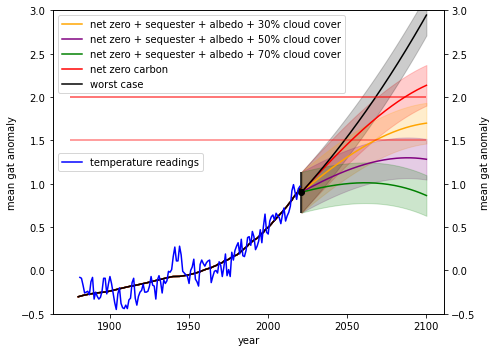

In [19]:
plt.rcParams["figure.figsize"] = (7,5)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#Polynomial prediction
degree = 2

# Worst case
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(vars_notime, gat)
temp = model.predict(vars_pred_notime)

# Albedo with clouds 30
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(vars_notime, gat)
temp = model.predict(vars_zero_notime)
lin = np.append(np.zeros(len(temp) - 80), np.linspace(0, temperature_difference(sahara_subpluvial_clouds_30, earth_deserts_surface), 80))
temp_clouds30 = temp + lin

df_gata['mean gat anomaly'] = temp + lin

s = seaborn.lineplot(data=df_gata, x='year' , y='mean gat anomaly', ax=ax1, color='orange')

# Albedo with clouds 50
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(vars_notime, gat)
temp = model.predict(vars_zero_notime)

lin = np.append(np.zeros(len(temp) - 80), np.linspace(0, temperature_difference(sahara_subpluvial_clouds_50, earth_deserts_surface), 80))

temp_clouds50 = temp + lin

df_gata['mean gat anomaly'] = temp + lin

s = seaborn.lineplot(data=df_gata, x='year' , y='mean gat anomaly', ax=ax1, color='purple')

# Albedo with clouds 70
model = make_pipeline(PolynomialFeatures(degree), Ridge())
# model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e0))
model.fit(vars_notime, gat)
temp = model.predict(vars_zero_notime)

lin = np.append(np.zeros(len(temp) - 80), np.linspace(0, temperature_difference(sahara_subpluvial_clouds_70, earth_deserts_surface), 80))

temp_clouds70 = temp + lin

df_gata['mean gat anomaly'] = temp + lin
s = seaborn.lineplot(data=df_gata, x='year' , y='mean gat anomaly', ax=ax1, color='green')

# Net Zero
temp = model.predict(vars_reduction_notime)
temp_zero = temp
df_gata['mean gat anomaly'] = temp
s = seaborn.lineplot(data=df_gata, x='year' , y='mean gat anomaly', ax=ax1, color='red')


# Worst case
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(vars_notime, gat)
temp = model.predict(vars_pred_notime)

temp_proj = temp

rmse = np.sqrt(mean_squared_error(temp[:-81], np.array(df_gat['mean gat anomaly'])))
df_gata['mean gat anomaly'] = np.array(temp) 

s = seaborn.lineplot(data=df_gata, x='year' , y='mean gat anomaly', ax=ax1, color='black')

s = seaborn.lineplot(data=df_gat, x='year' , y='mean gat anomaly', ax=ax2, color='blue')

ax1.errorbar(years[-80], temp[-80], yerr=2*rmse, color='black', fmt='o')

ax1.fill_between(years[-80:], np.array(temp_zero[-80:]) - 2*rmse, np.array(temp_zero[-80:]) + 2*rmse, alpha=.2, color='red')
ax1.fill_between(years[-80:], np.array(temp_proj[-80:]) - 2*rmse, np.array(temp_proj[-80:]) + 2*rmse, alpha=.2, color='black')
ax1.fill_between(years[-80:], np.array(temp_clouds30[-80:]) - 2*rmse, np.array(temp_clouds30[-80:]) + 2*rmse, alpha=.2, color='orange')
ax1.fill_between(years[-80:], np.array(temp_clouds50[-80:]) - 2*rmse, np.array(temp_clouds50[-80:]) + 2*rmse, alpha=.2, color='purple')
ax1.fill_between(years[-80:], np.array(temp_clouds70[-80:]) - 2*rmse, np.array(temp_clouds70[-80:]) + 2*rmse, alpha=.2, color='green')

# plt.legend(labels = ["co2", "co2+h2o", "readings"])
ax1.legend(labels = [ "net zero + sequester + albedo + 30% cloud cover",  "net zero + sequester + albedo + 50% cloud cover", "net zero + sequester + albedo + 70% cloud cover", "net zero carbon", "worst case"])
ax2.legend(labels = ["temperature readings"], loc="center left")
ax1.set_ylim([-0.5, 3])
ax2.set_ylim([-0.5, 3])
plt.hlines(1.50, 1875, 2100, colors='r', alpha=.5)
plt.hlines(2, 1875, 2100, colors='r', alpha=.7)
plt.tight_layout()

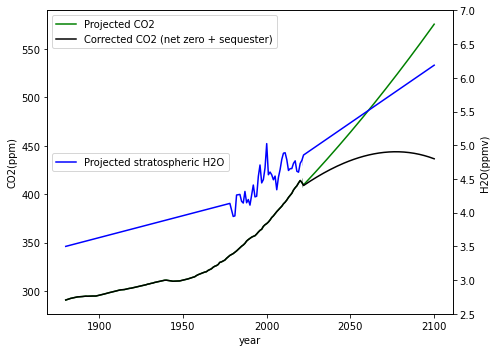

In [21]:
plt.rcParams["figure.figsize"] = (7,5)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


s = seaborn.lineplot(data=variables, x='year' , y='proj co2', ax=ax1, color='green')
s = seaborn.lineplot(data=variables,
                 x='year' , y='corrected co2', ax=ax1, color = 'black')
s = seaborn.lineplot(data=variables,
                 x='year' , y='proj h2o', ax=ax2, color = 'blue')

ax1.set_ylabel("CO2(ppm)")
ax2.set_ylabel("H2O(ppmv)")

ax2.set_ylim([2.5, 7])
ax1.legend(labels = ["Projected CO2", "Corrected CO2 (net zero + sequester)"])
ax2.legend(labels = ["Projected stratospheric H2O"], loc="center left")
plt.tight_layout()